In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [2]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm, PowerNorm
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy import stats
import scanpy
import seaborn as sb
import json

In [3]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [4]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [5]:
%%bash
pwd

/u/davidm/Documents/Master-thesis/Projects/scBC-Analysis/0_Preprocessing/2_Cells-filtering/dsp779


In [6]:
%%bash
tar czf ./figs.tar.gz ./figs/*.pdf

### Plotting parameters

In [7]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 6

### Load sample

In [807]:
# sample = "Sample_N701_-_Not_Transfected"
# sample = "Sample_N705_-_ER1"
# sample = "Sample_N702_-_CTR1"
# sample = "Sample_N707_-_ER2"
# sample = "Sample_MDAMB436_N705"
# sample = "Sample_MCF7-atcc"
# sample = "Sample_ZR75"
# sample = "Sample_HCC70_N703"

# new_sample_name = "NT"

quant_params_default = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/default"
quant_params_3000 = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000-old"
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/customWh-top-3000"

genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"

In [9]:
cell_cycle_genes = np.array(['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG',
       'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 'RFC2',
       'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2',
       'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6',
       'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN',
       'POLA1', 'CHAF1B', 'BRIP1', 'E2F8', 'HMGB2', 'CDK1', 'NUSAP1',
       'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2',
       'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'SMC4', 'CCNB2',
       'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B',
       'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'CDC20', 'TTK', 'CDC25C',
       'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2',
       'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE',
       'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA'])

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

g2m_genes = ['ABL1', 'AMD1', 'ARID4A', 'ATF5', 'ATRX', 'AURKA', 'AURKB',
       'BARD1', 'BCL3', 'BIRC5', 'BRCA2', 'BUB1', 'BUB3', 'CASP8AP2',
       'CBX1', 'CCNA2', 'CCNB2', 'CCND1', 'CCNF', 'CCNT1', 'CDC20',
       'CDC25A', 'CDC25B', 'CDC27', 'CDC45', 'CDC6', 'CDC7', 'CDK1',
       'CDK4', 'CDKN1B', 'CDKN2C', 'CDKN3', 'CENPA', 'CENPE', 'CENPF',
       'CHAF1A', 'CHEK1', 'CHMP1A', 'CKS1B', 'CKS2', 'CTCF', 'CUL1',
       'CUL3', 'CUL4A', 'CUL5', 'DBF4', 'DDX39A', 'DKC1', 'DMD', 'DR1',
       'DTYMK', 'E2F1', 'E2F2', 'E2F3', 'E2F4', 'EFNA5', 'EGF', 'ESPL1',
       'EWSR1', 'EXO1', 'EZH2', 'FANCC', 'FBXO5', 'FOXN3', 'G3BP1',
       'GINS2', 'GSPT1', 'H2AX', 'H2AZ1', 'H2AZ2', 'H2BC12', 'HIF1A',
       'HIRA', 'HMGA1', 'HMGB3', 'HMGN2', 'HMMR', 'HNRNPD', 'HNRNPU',
       'HOXC10', 'HSPA8', 'HUS1', 'ILF3', 'INCENP', 'JPT1', 'KATNA1',
       'KIF11', 'KIF15', 'KIF20B', 'KIF22', 'KIF23', 'KIF2C', 'KIF4A',
       'KIF5B', 'KMT5A', 'KNL1', 'KPNA2', 'KPNB1', 'LBR', 'LIG3', 'LMNB1',
       'MAD2L1', 'MAP3K20', 'MAPK14', 'MARCKS', 'MCM2', 'MCM3', 'MCM5',
       'MCM6', 'MEIS1', 'MEIS2', 'MKI67', 'MNAT1', 'MT2A', 'MTF2',
       'MYBL2', 'MYC', 'NASP', 'NCL', 'NDC80', 'NEK2', 'NOLC1', 'NOTCH2',
       'NSD2', 'NUMA1', 'NUP50', 'NUP98', 'NUSAP1', 'ODC1', 'ODF2',
       'ORC5', 'ORC6', 'PAFAH1B1', 'PBK', 'PDS5B', 'PLK1', 'PLK4', 'PML',
       'POLA2', 'POLE', 'POLQ', 'PRC1', 'PRIM2', 'PRMT5', 'PRPF4B',
       'PTTG1', 'PTTG3P', 'PURA', 'RACGAP1', 'RAD21', 'RAD23B', 'RAD54L',
       'RASAL2', 'RBL1', 'RBM14', 'RPA2', 'RPS6KA5', 'SAP30', 'SFPQ',
       'SLC12A2', 'SLC38A1', 'SLC7A1', 'SLC7A5', 'SMAD3', 'SMARCC1',
       'SMC1A', 'SMC2', 'SMC4', 'SNRPD1', 'SQLE', 'SRSF1', 'SRSF10',
       'SRSF2', 'SS18', 'STAG1', 'STIL', 'STMN1', 'SUV39H1', 'SYNCRIP',
       'TACC3', 'TENT4A', 'TFDP1', 'TGFB1', 'TLE3', 'TMPO', 'TNPO2',
       'TOP1', 'TOP2A', 'TPX2', 'TRA2B', 'TRAIP', 'TROAP', 'TTK', 'UBE2C',
       'UBE2S', 'UCK2', 'UPF1', 'WRN', 'XPO1', 'YTHDC1']

In [10]:
# sc._inplace_subset_obs(whitelist_default.values.ravel())

### Default NT

#### Load sample

In [808]:
sample = "Sample_N701_-_Not_Transfected"

project = "dsp779"

whitelist = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/alevin/whitelist.txt", header=None)[0].values

In [685]:
len(whitelist)

782

In [686]:
with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/aux_info/alevin_meta_info.json") as f:
    data = json.load(f)

In [687]:
data

{'total_reads': 115784803,
 'reads_with_N': 0,
 'noisy_cb_reads': 83468802,
 'noisy_umi_reads': 1746,
 'used_reads': 32314255,
 'mapping_rate': 25.393337673165966,
 'reads_in_eqclasses': 29401626,
 'total_cbs': 3156724,
 'used_cbs': 46009,
 'initial_whitelist': 900,
 'low_conf_cbs': 450,
 'num_features': 7,
 'final_num_cbs': 782,
 'deduplicated_umis': 6320571,
 'mean_umis_per_cell': 8082,
 'mean_genes_per_cell': 3447}

In [688]:
knee = data["initial_whitelist"]
low_conf = data["low_conf_cbs"]
f = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/alevin/quants_mat_rows.txt", header=None).values.ravel()
freq = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/alevin/raw_cb_frequency.txt", header=None, index_col=0).loc[f]
knee_cbs = freq[:knee].index
low_conf_cbs = freq[knee:knee+low_conf].index

In [809]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc.obs_names = sc.obs["CB"]

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_genes(sc, "gene_biotype")
x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "Mt_rRNA"]
sc.obs["Mt_rRNA"] = x.sum(1) / sc.obs["total_UMIs"]
rnaseq.setup.annotate_samples(sc, "mt_frac")
rnaseq.setup.annotate_samples(sc, "max_corr")
rnaseq.setup.annotate_samples(sc, "#_genes")

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/customWh-top-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating total_UMIs...
Annotating gene_biotype using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...
Annotating #_genes...


UnboundLocalError: local variable 'x' referenced before assignment

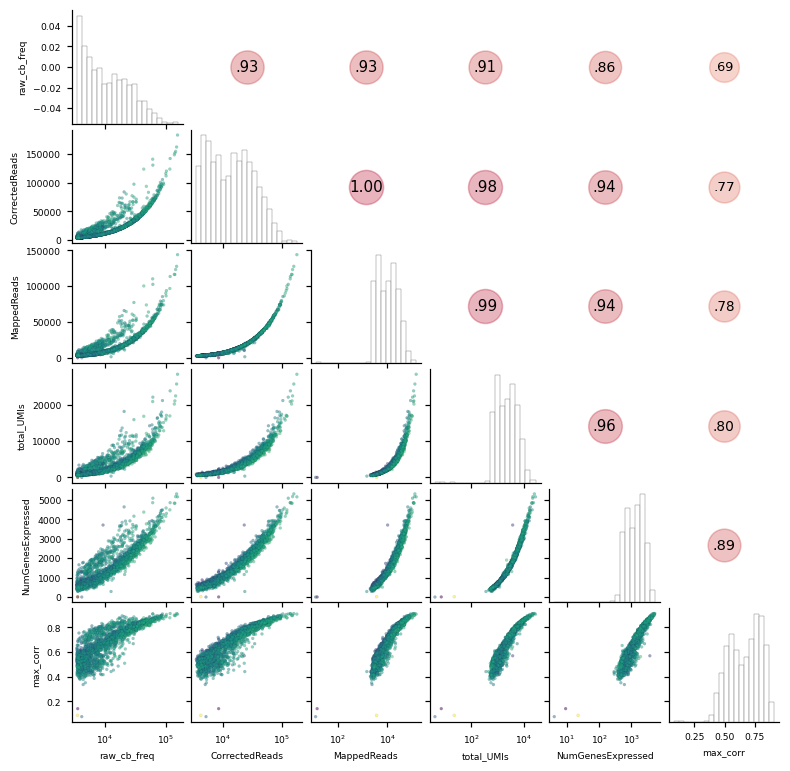

In [811]:
metrics = ['raw_cb_freq', 'CorrectedReads', 'MappedReads', 'total_UMIs', 'NumGenesExpressed', 'max_corr']

df = sc.obs[metrics]
  
g = sb.PairGrid(df, aspect=1, diag_sharey=False)
g.map_lower(sb.scatterplot, edgecolor = 'black', c = sc.obs["DedupRate"], linewidth = 0.05, s = 4, alpha = 0.5)
g.map_upper(corrdot)
g.fig.set_size_inches(6.8,6.8)
for i in range(len(metrics)-1):
    for gi in g.axes[i,:] :
        gi.set_yscale('log')
        gi.minorticks_off()
    for gi in g.axes[:,i] :
        gi.set_xscale('log')
        gi.minorticks_off()
g.map_diag(sb.histplot, bins = 20, color="white", edgecolor="gray", linewidth = 0.3);
plt.savefig("./figs/pairwise_qc_metrics.pdf")

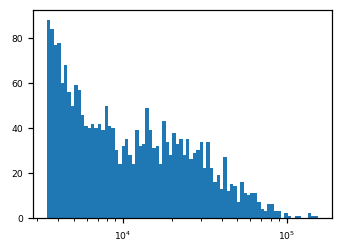

In [817]:
rnaseq.plotting.loghist(sc.obs["raw_cb_freq"]);

In [254]:
sc.obs.loc[sc.obs_names[np.array([(cb in whitelist and cb not in knee_cbs) for cb in sc.obs_names])]]

,CB,CorrectedReads,MappedReads,DeduplicatedReads,MappingRate,DedupRate,MeanByMax,NumGenesExpressed,NumGenesOverMean,raw_cb_freq,samples,project_id,total_UMIs,Mt_rRNA,mt_frac
CB,,,,,,,,,,,,,,,


In [121]:
sc.X.shape

(2271, 60240)

In [143]:
sc.X.shape

(2267, 60240)

In [144]:
sc_copy = sc.copy()

#### Before filtering

In [141]:
sc = sc_copy.copy()

In [115]:
sc.obs["total_UMIs"].median()

2370.0

In [116]:
sc.obs["total_UMIs"].min()

358.0

Normalization by total UMIs...
Log2 + 1 tranformation...


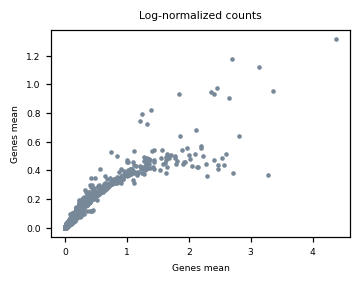

In [132]:
tot=sc.obs["total_UMIs"].mean() - sc.obs["total_UMIs"].median()
rnaseq.pp.log_norm(sc, plot=True, inplace=True, ow = True, verbose = True, tot=tot)
scanpy.pp.pca(sc, n_comps=50)
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors=15)
scanpy.tl.umap(sc, n_components=2)

In [133]:
rnaseq.setup.annotate_genes(sc)
sc.var_names = sc.var["external_gene_name"].values
sc.var_names = np.array(sc.var_names.values)
sc.var_names_make_unique()
scanpy.tl.score_genes_cell_cycle(sc, s_genes=s_genes, g2m_genes=g2m_genes)

Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


/tmp/ipykernel_36971/2506179637.py:9: UserWarning: You passed a edgecolor/edgecolors ('indianred') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\


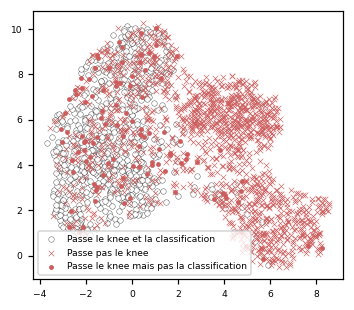

In [134]:
scatt = plt.subplots(figsize=(3.2,2.8))

i2 = np.array([cb in whitelist for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.2, edgecolors = "black", label = "Passe le knee et la classification",\
            s = 13, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in knee_cbs for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\
            s = 13, vmin = -0.5, vmax = 1.5, alpha=1, color = "indianred", edgecolors = "indianred", linewidths=0.4)


i3 = np.array([(cb not in whitelist and cb in knee_cbs) for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
            s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)


plt.legend()
plt.tight_layout()
plt.savefig("./figs/NT_before_filtering.pdf")

In [104]:
i1.sum()+i2.sum()+i3.sum()

2267

In [105]:
sc.X.shape

(2267, 60240)

external_gene_name already annotated. Set ow = True if you want to overwrite.


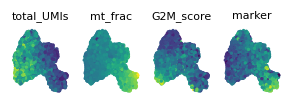

In [135]:
rnaseq.setup.annotate_genes(sc)
sc.obs["marker"] = sc.X.toarray()[:, sc.var["external_gene_name"].values == "MALAT1"]

scatt = plt.subplots(figsize=(4,0.8), sharey=True)
for i,(c,p) in enumerate(zip(["total_UMIs", "mt_frac", "G2M_score", "marker"],[1,0.3,1,1])):
    axi = plt.subplot(1,5,i+1)
    plt.title(c)
    if c == "total_UMIs" :
        plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = LogNorm())
    else :
        plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = PowerNorm(p))
    plt.axis('off')

plt.savefig("./figs/NT_metrics_before_filtering.pdf")

In [136]:
sc.X.shape

(2267, 60240)

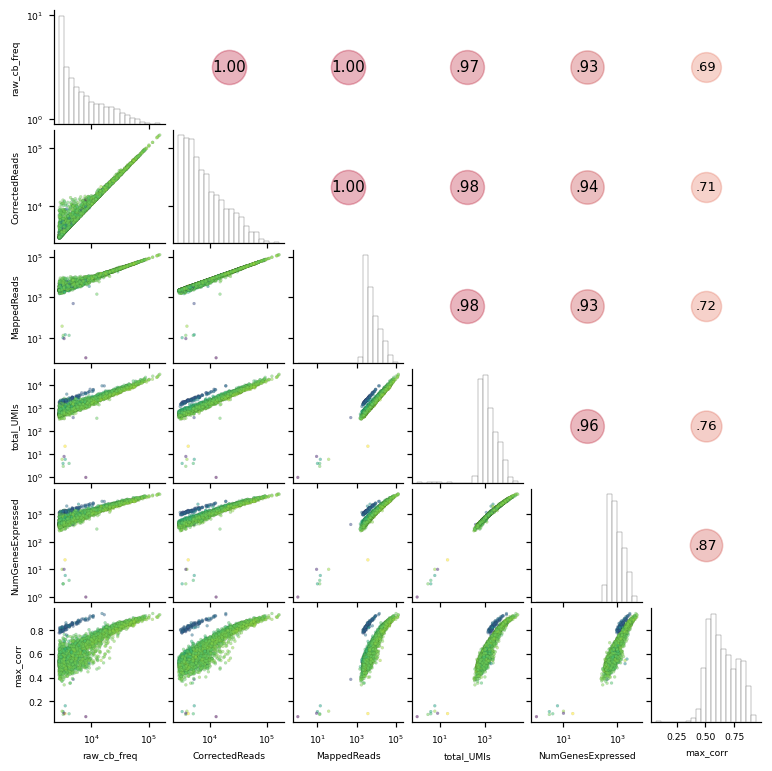

In [698]:
metrics = ['raw_cb_freq', 'CorrectedReads', 'MappedReads', 'total_UMIs', 'NumGenesExpressed', 'max_corr']

df = sc.obs[metrics]
  
g = sb.PairGrid(df, aspect=1, diag_sharey=False)
g.map_lower(sb.scatterplot, edgecolor = 'black', c = sc.obs["DedupRate"], linewidth = 0.05, s = 4, alpha = 0.5)
g.map_upper(corrdot)
g.fig.set_size_inches(6.8,6.8)
for i in range(len(metrics)-1):
    for gi in g.axes[i,:] :
        gi.set_yscale('log')
        gi.minorticks_off()
    for gi in g.axes[:,i] :
        gi.set_xscale('log')
        gi.minorticks_off()
g.map_diag(sb.histplot, bins = 20, color="white", edgecolor="gray", linewidth = 0.3);
plt.savefig("./figs/pairwise_qc_metrics.pdf")

#### After filtering

In [66]:
sc = rnaseq.readwrite.read_filtered(samples = {"dsp779": "NT"})

In [68]:
rnaseq.pp.log_norm(sc, plot=False, inplace=True, ow = True, verbose = True)
scanpy.pp.pca(sc, n_comps=50)
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors=15)
scanpy.tl.umap(sc, n_components=2)

Normalization by total UMIs...
Log2 + 1 tranformation...


/tmp/ipykernel_36971/2807810485.py:9: UserWarning: You passed a edgecolor/edgecolors ('indianred') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\


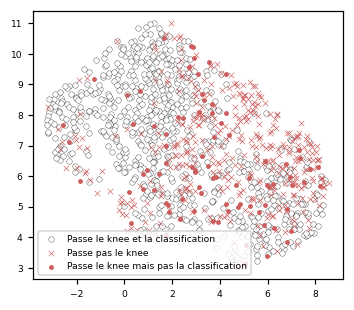

In [78]:
scatt = plt.subplots(figsize=(3.2,2.8))

i2 = np.array([cb in whitelist for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.2, edgecolors = "black", label = "Passe le knee et la classification",\
            s = 13, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in knee_cbs for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\
            s = 13, vmin = -0.5, vmax = 1.5, alpha=1, color = "indianred", edgecolors = "indianred", linewidths=0.4)


i3 = np.array([(cb not in whitelist and cb in knee_cbs) for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
            s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)


plt.legend()
plt.tight_layout()
plt.savefig("./figs/NT_after_filtering.pdf")

In [75]:
i1.sum()+i2.sum()+i3.sum()

1189

In [76]:
sc.X.shape

(1189, 60240)

external_gene_name already annotated. Set ow = True if you want to overwrite.


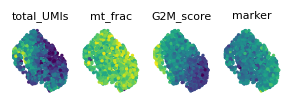

In [79]:
rnaseq.setup.annotate_genes(sc)
sc.obs["marker"] = sc.X.toarray()[:, sc.var["external_gene_name"].values == "MALAT1"]

scatt = plt.subplots(figsize=(4,0.8), sharey=True)
for i,(c,p) in enumerate(zip(["total_UMIs", "mt_frac", "G2M_score", "marker"],[1,0.5,1,1])):
    axi = plt.subplot(1,5,i+1)
    plt.title(c)
    if c == "total_UMIs" :
        plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = LogNorm())
    else :
        plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = PowerNorm(p))
    plt.axis('off')

plt.savefig("./figs/NT_metrics_after_filtering.pdf")

In [80]:
sc.X.shape

(1189, 60240)

### ForceCells NT

In [258]:
sample = "Sample_N701_-_Not_Transfected"
project = "dsp779"

whitelist = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/whitelist.txt", header=None)[0].values

In [259]:
len(whitelist)

2078

In [145]:
sc = sc_copy.copy()

In [260]:
with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/aux_info/alevin_meta_info.json") as f:
    data = json.load(f)

In [261]:
data

{'total_reads': 115784803,
 'reads_with_N': 0,
 'noisy_cb_reads': 71670429,
 'noisy_umi_reads': 2327,
 'used_reads': 44112047,
 'mapping_rate': 32.97449493436544,
 'reads_in_eqclasses': 38179454,
 'total_cbs': 3156724,
 'used_cbs': 83814,
 'initial_whitelist': 3000,
 'low_conf_cbs': 1000,
 'num_features': 7,
 'final_num_cbs': 2078,
 'deduplicated_umis': 8608663,
 'mean_umis_per_cell': 4142,
 'mean_genes_per_cell': 2107}

In [262]:
knee = data["initial_whitelist"]
low_conf = data["low_conf_cbs"]
f = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/quants_mat_rows.txt", header=None).values.ravel()
freq = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/raw_cb_frequency.txt", header=None, index_col=0).loc[f]
knee_cbs = freq[:knee].index
low_conf_cbs = freq[knee:knee+low_conf].index

In [263]:
len(knee_cbs)

3000

In [264]:
len(low_conf_cbs)

1000

In [265]:
sc.obs.loc[sc.obs_names[np.array([(cb in whitelist and cb not in knee_cbs) for cb in sc.obs_names])]]

,CB,CorrectedReads,MappedReads,DeduplicatedReads,MappingRate,DedupRate,MeanByMax,NumGenesExpressed,NumGenesOverMean,raw_cb_freq,samples,project_id,total_UMIs,Mt_rRNA,mt_frac
CB,,,,,,,,,,,,,,,


#### Before filtering

In [160]:
sc = sc_copy.copy()

In [161]:
rnaseq.pp.log_norm(sc, plot=False, inplace=True, ow = True, verbose = True)
scanpy.pp.pca(sc, n_comps=50)
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors=15)
scanpy.tl.umap(sc, n_components=2)

Normalization by total UMIs...
Log2 + 1 tranformation...


/tmp/ipykernel_36971/3271054050.py:9: UserWarning: You passed a edgecolor/edgecolors ('indianred') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\


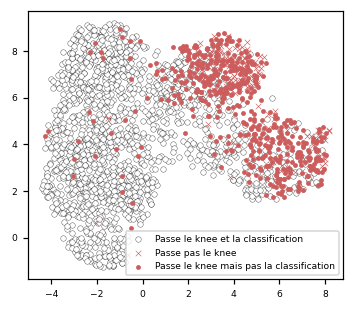

In [162]:
scatt = plt.subplots(figsize=(3.2,2.8))

i2 = np.array([cb in whitelist for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.2, edgecolors = "black", label = "Passe le knee et la classification",\
            s = 13, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in knee_cbs for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\
            s = 13, vmin = -0.5, vmax = 1.5, alpha=1, color = "indianred", edgecolors = "indianred", linewidths=0.4)


i3 = np.array([(cb not in whitelist and cb in knee_cbs) for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
            s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)


plt.legend()
plt.tight_layout()
plt.savefig("./figs/NT_before_filtering_forcecells.pdf")

In [154]:
i1.sum()+i2.sum()+i3.sum()

2267

In [155]:
sc.X.shape

(2267, 60240)

Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


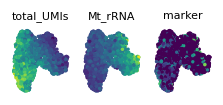

In [156]:
rnaseq.setup.annotate_genes(sc)
sc.obs["marker"] = sc.X.toarray()[:, sc.var["external_gene_name"].values == "LXN"]

scatt = plt.subplots(figsize=(3.2,0.8), sharey=True)
for i,(c,p) in enumerate(zip(["total_UMIs", "Mt_rRNA", "marker"],[1,0.5,1])):
    axi = plt.subplot(1,4,i+1)
    plt.title(c)
    if c == "total_UMIs" :
        plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = LogNorm())
    else :
        plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = PowerNorm(p))
    plt.axis('off')

#### After filtering

In [157]:
sc = rnaseq.readwrite.read_filtered(samples = {"dsp779": "NT"})

In [158]:
rnaseq.pp.log_norm(sc, plot=False, inplace=True, ow = True, verbose = True)
scanpy.pp.pca(sc, n_comps=50)
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors=15)
scanpy.tl.umap(sc, n_components=2)

Normalization by total UMIs...
Log2 + 1 tranformation...


/tmp/ipykernel_36971/2131592503.py:9: UserWarning: You passed a edgecolor/edgecolors ('indianred') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\


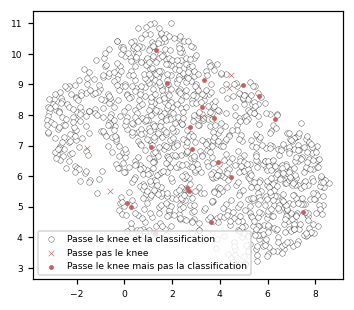

In [159]:
scatt = plt.subplots(figsize=(3.2,2.8))

i2 = np.array([cb in whitelist for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.2, edgecolors = "black", label = "Passe le knee et la classification",\
            s = 13, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in knee_cbs for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\
            s = 13, vmin = -0.5, vmax = 1.5, alpha=1, color = "indianred", edgecolors = "indianred", linewidths=0.4)


i3 = np.array([(cb not in whitelist and cb in knee_cbs) for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
            s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)


plt.legend()
plt.tight_layout()
plt.savefig("./figs/NT_after_filtering_forcecells.pdf")

In [ ]:
rnaseq.setup.annotate_genes(sc)
sc.obs["marker"] = sc.X.toarray()[:, sc.var["external_gene_name"].values == "LXN"]

scatt = plt.subplots(figsize=(3.2,0.8), sharey=True)
for i,(c,p) in enumerate(zip(["total_UMIs", "Mt_rRNA", "marker"],[1,0.5,1])):
    axi = plt.subplot(1,4,i+1)
    plt.title(c)
    if c == "total_UMIs" :
        plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = LogNorm())
    else :
        plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = PowerNorm(p))
    plt.axis('off')

In [ ]:
sc.X.shape

### Default ER1

In [977]:
quant_params_default = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/default-old"
quant_params_3000 = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-400"
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/customWh-top-3000"

genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
sample = "Sample_N705_-_ER1"


project = "dsp779"

whitelist_defaut = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/alevin/whitelist.txt", header=None)[0].values
whitelist_3000 = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/whitelist.txt", header=None)[0].values

In [978]:
len(whitelist_defaut)

66

In [979]:
len(whitelist_3000)

267

In [980]:
with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/aux_info/alevin_meta_info.json") as f:
    data = json.load(f)

In [981]:
data

{'total_reads': 159449547,
 'reads_with_N': 0,
 'noisy_cb_reads': 84181718,
 'noisy_umi_reads': 4075,
 'used_reads': 75263754,
 'mapping_rate': 42.772304646309216,
 'reads_in_eqclasses': 68200246,
 'total_cbs': 2280250,
 'used_cbs': 15236,
 'initial_whitelist': 91,
 'low_conf_cbs': 201,
 'num_features': 7,
 'final_num_cbs': 66,
 'deduplicated_umis': 1792127,
 'mean_umis_per_cell': 27153,
 'mean_genes_per_cell': 10047}

In [982]:
knee = data["initial_whitelist"]
low_conf = data["low_conf_cbs"]
freq = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/alevin/raw_cb_frequency.txt", header=None, index_col=0) #.loc[f]
knee_cbs_defaut = freq[:knee].index
# f = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/alevin/quants_mat_rows.txt", header=None).values.ravel()
# knee_cbs_defaut = np.intersect1d(knee_cbs_defaut,f)
# low_conf_cbs = freq[knee:knee+low_conf].index

In [983]:
len(freq)

2280250

In [984]:
len(knee_cbs_defaut)

91

In [985]:
with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/aux_info/alevin_meta_info.json") as f:
    data = json.load(f)

In [986]:
data

{'total_reads': 159449547,
 'reads_with_N': 0,
 'noisy_cb_reads': 74549309,
 'noisy_umi_reads': 4410,
 'used_reads': 84895828,
 'mapping_rate': 46.10319212760134,
 'reads_in_eqclasses': 73511331,
 'total_cbs': 2280250,
 'used_cbs': 24794,
 'initial_whitelist': 400,
 'low_conf_cbs': 201,
 'num_features': 7,
 'final_num_cbs': 267,
 'deduplicated_umis': 2229912,
 'mean_umis_per_cell': 8351,
 'mean_genes_per_cell': 3455}

In [987]:
knee = data["initial_whitelist"]
low_conf = data["low_conf_cbs"]
freq = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/raw_cb_frequency.txt", header=None, index_col=0) #.loc[f]
knee_cbs_3000 = freq[:knee].index
# f = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/quants_mat_rows.txt", header=None).values.ravel()
# knee_cbs_3000 = np.intersect1d(knee_cbs_3000,f)
# low_conf_cbs = freq[knee:knee+low_conf].index

In [988]:
len(knee_cbs_3000)

400

In [989]:
len(freq)

2280250

In [832]:
# i = np.argwhere(np.array([(cb in whitelist_defaut) & (cb not in knee_cbs_defaut) for cb in freq.index])).ravel()

In [990]:
sc.obs.loc[sc.obs_names[np.array([(cb in whitelist_defaut and cb not in knee_cbs_defaut) for cb in sc.obs_names])]]

,CB,CorrectedReads,MappedReads,DeduplicatedReads,MappingRate,DedupRate,MeanByMax,NumGenesExpressed,NumGenesOverMean,raw_cb_freq,...,lncRNA,rRNA,Mt_rRNA,protein_coding,processed_pseudogene,hsp_frac,S_score,G2M_score,phase,marker
ACGGCGGAACAG,ACGGCGGAACAG,547504,436880,9821,0.797949,0.97752,0.019914,3266,513,243250,...,0.020178,0.0,0.012211,0.946201,0.013846,0.013542,0.002882,0.017549,G2M,1.745176


In [991]:
sc.obs.loc[sc.obs_names[np.array([(cb in whitelist_3000 and cb not in knee_cbs_3000) for cb in sc.obs_names])]]

,CB,CorrectedReads,MappedReads,DeduplicatedReads,MappingRate,DedupRate,MeanByMax,NumGenesExpressed,NumGenesOverMean,raw_cb_freq,...,lncRNA,rRNA,Mt_rRNA,protein_coding,processed_pseudogene,hsp_frac,S_score,G2M_score,phase,marker
CCCTCATGTGCG,CCCTCATGTGCG,70453,53644,2974,0.761415,0.944560,0.038339,1763,468,30140,...,0.018449,0.0,0.009079,0.959214,0.005828,0.016140,-0.004056,0.015428,G2M,0.000000
TTCGGAACCCCG,TTCGGAACCCCG,61157,46638,2549,0.762595,0.945345,0.027809,1291,424,23241,...,0.017981,0.0,0.014908,0.953092,0.008396,0.008239,-0.015660,0.013560,G2M,1.491941


In [992]:
len(whitelist_3000)

267

In [993]:
print(len(quants_mat_rows))
print(knee)

3999
400


In [994]:
print(len(whitelist_defaut))
print(len(np.intersect1d(knee_cbs_defaut, whitelist_defaut)))
# print(len(np.intersect1d(quants_mat_rows[:knee], whitelist)))

66
65


In [995]:
raw_cb_frequency.loc[quants_mat_rows[:5]]

,1
0,
CTTTGAGAGCAT,311379
CCTGCGGCGCAA,344633
CCACCCCGTCTA,360590
GGCATCGATAGG,376217
ACCGGATGGCAT,481767


In [996]:
print(len(whitelist))
print(len(np.intersect1d(raw_cb_frequency[:1500].index, whitelist)))
print(len(np.intersect1d(quants_mat_rows[:1500], whitelist)))

2972
3
3


#### Before filtering

In [997]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc.obs_names = sc.obs["CB"].tolist()

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/customWh-top-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [958]:
np.sort(sc.obs["total_UMIs"])[::-1][1500]

97.0

In [968]:
(sc.obs["total_UMIs"] > 400).sum()

420

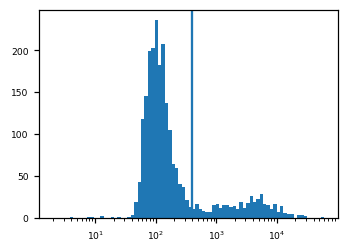

In [967]:
rnaseq.plotting.loghist(sc.obs["total_UMIs"]);
plt.axvline(400)

In [998]:
rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")

Annotating total_UMIs...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


In [869]:
sc.obs["marker"] = sc.X.toarray()[:, sc.var["external_gene_name"].values == "CCNB1"]

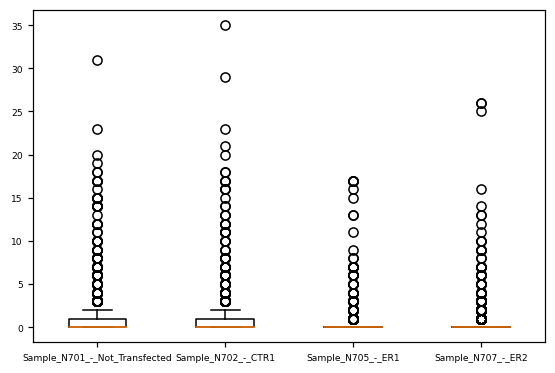

In [870]:
plt.boxplot([sc.obs.loc[sc.obs_names[sc.obs["samples"] == s]]["marker"] for s in np.unique(sc.obs["samples"])], labels=np.unique(sc.obs["samples"]));

In [871]:
features

,CorrectedReads,MappedReads,DeduplicatedReads,MappingRate,DedupRate,MeanByMax,NumGenesExpressed,NumGenesOverMean,mRnaFraction,rRnaFraction,raw_cb_freq
CB,,,,,,,,,,,
CTTTGAGAGCAT,325328,264226,22829,0.812183,0.913600,0.021156,5066,1055,0.0,0.020051,311379
CCTGCGGCGCAA,364990,290965,22162,0.797186,0.923833,0.016330,5008,1028,0.0,0.017767,344633
CCACCCCGTCTA,387125,308124,27437,0.795929,0.910955,0.020936,5349,985,0.0,0.033435,360590
GGCATCGATAGG,399260,319189,26992,0.799451,0.915436,0.018875,5129,952,0.0,0.027429,376217
ACCGGATGGCAT,505247,408607,40930,0.808727,0.899830,0.015085,6048,1163,0.0,0.021170,481767
...,...,...,...,...,...,...,...,...,...,...,...
CTCCGATTCTCC,2214,1444,141,0.652213,0.902355,0.097107,132,11,0.0,0.088652,2170
CCGCGGGTGCGG,2195,1391,268,0.633713,0.807333,0.064875,243,24,0.0,0.085821,2114
CACAGCCATCAT,2193,1570,181,0.715914,0.884713,0.258571,175,14,0.0,0.044199,2145


In [837]:
sc.X.shape

(2264, 60240)

In [999]:
quant_params_1 = "trimmed-reads-cutadapt-all/no-decoys-k19-1.4.0/forceCells-3000"
sc1 = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_1, genref = genref, cdna = "3' tag", exp = "sc")
sc1.obs_names = sc1.obs["CB"]

quant_params_2 = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000"
sc2 = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_2, genref = genref, cdna = "3' tag", exp = "sc")
sc2.obs_names = sc2.obs["CB"]

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/no-decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [1000]:
sc.obs["genomic"] = 1-(sc2.obs["MappedReads"].loc[sc.obs_names]/sc1.obs["MappedReads"].loc[sc.obs_names])
del sc1,sc2

In [1001]:
rnaseq.setup.annotate_genes(sc, "gene_biotype")
rnaseq.setup.annotate_genes(sc, "chromosome_name")
rnaseq.setup.annotate_genes(sc)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac")

Annotating gene_biotype using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
chromosome_name already annotated. Set ow = True if you want to overwrite.
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
total_UMIs already annotated. Set ow = True if you want to overwrite.
Annotating #_genes...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...
mt_frac already annotated. Set ow = True if you want to overwrite.
Annotating rp_frac...
external_gene_name already annotated. Set ow = True if you want to overwrite.


In [1002]:
# x = sc.layers["raw"].toarray()[:, (sc.var["gene_biotype"] == "lncRNA") & (sc.var["external_gene_name"] != "MALAT1")]
x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "lncRNA"]
sc.obs["lncRNA"] = x.sum(1) / sc.obs["total_UMIs"]

x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "rRNA"]
sc.obs["rRNA"] = x.sum(1) / sc.obs["total_UMIs"]

x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "Mt_rRNA"]
sc.obs["Mt_rRNA"] = x.sum(1) / sc.obs["total_UMIs"]

x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "protein_coding"]
sc.obs["protein_coding"] = x.sum(1) / sc.obs["total_UMIs"]

x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "processed_pseudogene"]
sc.obs["processed_pseudogene"] = x.sum(1) / sc.obs["total_UMIs"]

In [1003]:
# sc._inplace_subset_obs(sc.obs["total_UMIs"] > 100)
# rnaseq.pp.filter_cells(sc, n_counts_min=20, inplace=True)
# filter_outliers(sc, "DedupRate")
rnaseq.pp.filter_genes(sc)

In [1004]:
rnaseq.pp.log_norm(sc, plot=False, inplace=True, ow = True, verbose = True)
scanpy.pp.pca(sc, n_comps=50)
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors=15)
scanpy.tl.umap(sc, n_components=2)

Normalization by total UMIs...
Log2 + 1 tranformation...


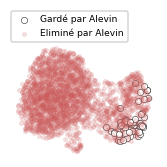

In [943]:
scatt,axi = plt.subplots(figsize=(1.5,1.5))

i2 = np.array([cb in whitelist_defaut for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.3, edgecolors = "black", label = "Gardé par Alevin",\
            s = 17, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in whitelist_defaut for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='o', label = "Eliminé par Alevin",\
            s = 7, vmin = -0.5, vmax = 1.5, alpha=0.2, color = "indianred", edgecolors = "indianred", linewidths=0.4)


# i3 = np.array([(cb not in whitelist_defaut and cb in knee_cbs_defaut) for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
#             s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)

axi.spines['right'].set_visible(False)
axi.spines['left'].set_visible(False)
axi.spines['bottom'].set_visible(False)
axi.spines['top'].set_visible(False)
axi.set_yticks([])
axi.set_xticks([])

plt.legend(loc=(0,1.01))
plt.tight_layout()
plt.savefig("./figs/ER1_before_filtering_defaut.pdf")

In [944]:
i1.sum()+i2.sum()+i3.sum()

2290

In [551]:
sc.X.shape

(2304, 20305)

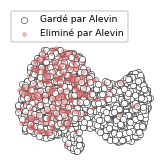

In [945]:
scatt,axi = plt.subplots(figsize=(1.5,1.5))

i2 = np.array([cb in whitelist_3000 for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.3, edgecolors = "black", label = "Gardé par Alevin",\
            s = 17, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in whitelist_3000 for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='o', label = "Eliminé par Alevin",\
            s = 7, vmin = -0.5, vmax = 1.5, alpha=0.4, color = "indianred", edgecolors = "indianred", linewidths=0.4)


# i3 = np.array([(cb not in whitelist_defaut and cb in knee_cbs_defaut) for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
#             s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)

axi.spines['right'].set_visible(False)
axi.spines['left'].set_visible(False)
axi.spines['bottom'].set_visible(False)
axi.spines['top'].set_visible(False)
axi.set_yticks([])
axi.set_xticks([])

plt.legend(loc=(0,1.01))
plt.tight_layout()
plt.savefig("./figs/ER1_before_filtering_3000.pdf")

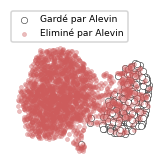

In [974]:
scatt,axi = plt.subplots(figsize=(1.5,1.5))

i2 = np.array([cb in whitelist_3000 for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.3, edgecolors = "black", label = "Gardé par Alevin",\
            s = 17, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in whitelist_3000 for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='o', label = "Eliminé par Alevin",\
            s = 7, vmin = -0.5, vmax = 1.5, alpha=0.4, color = "indianred", edgecolors = "indianred", linewidths=0.4)


# i3 = np.array([(cb not in whitelist_defaut and cb in knee_cbs_defaut) for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
#             s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)

axi.spines['right'].set_visible(False)
axi.spines['left'].set_visible(False)
axi.spines['bottom'].set_visible(False)
axi.spines['top'].set_visible(False)
axi.set_yticks([])
axi.set_xticks([])

plt.legend(loc=(0,1.01))
plt.tight_layout()
plt.savefig("./figs/ER1_before_filtering_3000.pdf")

In [553]:
i1.sum()+i2.sum()

2304

In [554]:
sc.X.shape

(2304, 20305)

In [555]:
# rnaseq.setup.annotate_genes(sc)
# sc.obs["marker"] = sc.X.toarray()[:, sc.var["external_gene_name"].values == "LXN"]

# scatt = plt.subplots(figsize=(3.4,0.8), sharey=True)
# for i,(c,p) in enumerate(zip(["total_UMIs", "mt_frac", "DedupRate", "marker"],[1,0.5,2.2,1])):
#     axi = plt.subplot(1,5,i+1)
#     plt.title(c)
#     if c == "total_UMIs" :
#         plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1, norm = LogNorm())
#     else :
#         plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1, norm = PowerNorm(p))
#     plt.axis('off')

# plt.savefig("./figs/ER1_before_filtering_metrics.pdf")

In [1007]:
sc.obs["marker"] = sc.X.toarray()[:, sc.var["external_gene_name"].values == "TFF1"]

In [1006]:
metrics = ['total_UMIs', '#_genes', 'max_corr', 'MappingRate','DedupRate', 'genomic', 'marker']
# metrics = ['total_UMIs', 'MeanByMax', 'NumGenesOverMean', 'MappingRate','DedupRate', 'genomic', 'marker']

powers_metrics = [0.1,0.3,0.8,1.3,1.5,0.5,0.8]

In [1008]:
biotypes = ['rRNA', 'Mt_rRNA', 'mt_frac', 'rp_frac', 'lncRNA', 'processed_pseudogene', 'protein_coding']
powers_biotypes = [1,0.5,0.5,0.5,0.55,0.5, 0.7]

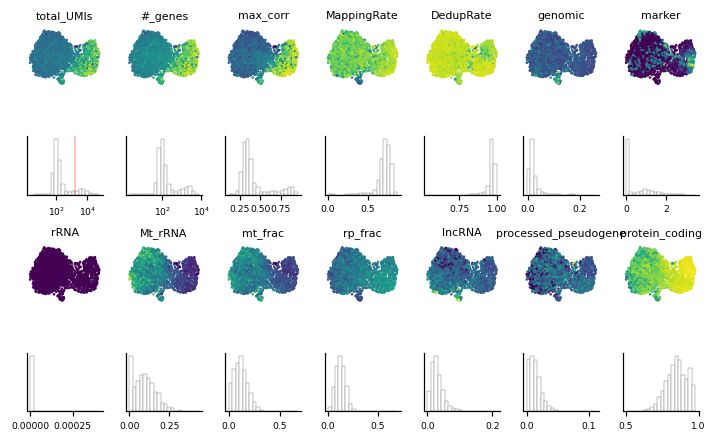

In [1009]:
scatt = plt.subplots(figsize=(6.5,4), sharey=True)
for i,(c,p) in enumerate(zip(metrics,powers_metrics)):
    axi = plt.subplot(4,7,i+1)
    plt.title(c)
    if metrics[i] in ["total_UMIs", "#_genes"] :
        norm = LogNorm()
    else : 
        norm = PowerNorm(p)
    plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 0.5, norm = norm)
    plt.axis('off')

for j,c in enumerate(metrics):
    axi = plt.subplot(4,7,i+j+2)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_yticks([])
    if metrics[j] in ["total_UMIs", "#_genes"] :
        rnaseq.plotting.loghist(sc.obs[c],  bins = 20, color="white", edgecolor="gray", linewidth = 0.3, ax=axi);
    else :
        plt.hist(sc.obs[c],  bins = 20, color="white", edgecolor="gray", linewidth = 0.3);
    if metrics[j] == "total_UMIs" :
        plt.axvline(1500, c='red', linewidth=0.3)

for a,(c,p) in enumerate(zip(biotypes,powers_biotypes)):
    axi = plt.subplot(4,7,a+i+j+3)
    plt.title(c)
    norm = PowerNorm(p)
    plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 0.5, norm = norm)    
    plt.axis('off')

for b,c in enumerate(biotypes):
    axi = plt.subplot(4,7,b+i+j+10)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_yticks([])
    plt.hist(sc.obs[c],  bins = 20, color="white", edgecolor="gray", linewidth = 0.3);


plt.tight_layout()
plt.savefig("./figs/metrics_before_filtering.pdf")

In [842]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 400 + 100
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.3, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 5 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

In [843]:
# sc.obs["CorrRate"] = 1 - (sc.obs["CorrectedReads"] / sc.obs["raw_cb_freq"])

In [880]:
i

4

/u/davidm/VirtualEns/python_3.9.5/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: autodetected range of [-inf, 3.1010593549081156] is not finite

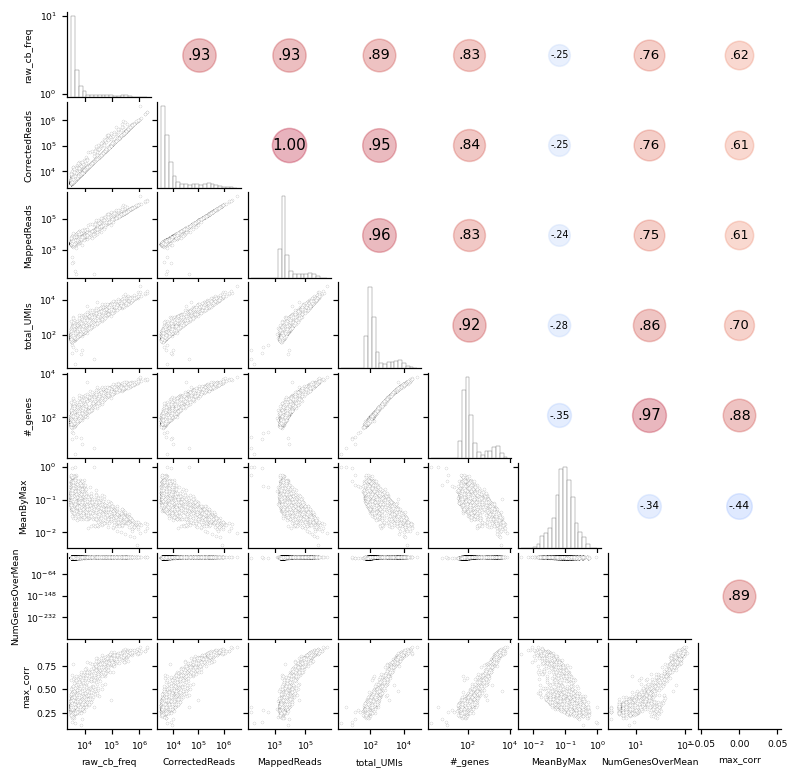

In [952]:
metrics = ['raw_cb_freq', 'CorrectedReads', 'MappedReads', 'total_UMIs', '#_genes', 'MeanByMax', 'NumGenesOverMean', 'max_corr']

df = sc.obs[metrics]
  
g = sb.PairGrid(df, aspect=1, diag_sharey=False)
g.map_lower(sb.scatterplot, edgecolor = 'black', color = 'white', linewidth = 0.05, s = 4)
g.map_upper(corrdot)
g.fig.set_size_inches(6.8,6.8)
for i in range(len(metrics)-1):
    for gi in g.axes[i,:] :
        gi.set_yscale('log')
        gi.minorticks_off()
    for gi in g.axes[:,i] :
        gi.set_xscale('log')
        gi.minorticks_off()
        
g.map_diag(sb.histplot, bins = 20, color="white", edgecolor="gray", linewidth = 0.3);
plt.savefig("./figs/pairwise_qc_metrics.pdf")

#### After filtering

In [975]:
sc = rnaseq.readwrite.read_filtered(samples = {"dsp779": "ER1"})

In [923]:
quant_params_1 = "trimmed-reads-cutadapt-all/no-decoys-k19-1.4.0/forceCells-3000"
sc1 = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_1, genref = genref, cdna = "3' tag", exp = "sc")
sc1.obs_names = sc1.obs["CB"]

quant_params_2 = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000"
sc2 = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_2, genref = genref, cdna = "3' tag", exp = "sc")
sc2.obs_names = sc2.obs["CB"]

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/no-decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [924]:
sc.obs["genomic"] = 1-(sc2.obs["DeduplicatedReads"].loc[sc.obs_names]/sc1.obs["DeduplicatedReads"].loc[sc.obs_names])
del sc1,sc2

In [925]:
rnaseq.setup.annotate_genes(sc, "gene_biotype")
rnaseq.setup.annotate_genes(sc, "chromosome_name")
rnaseq.setup.annotate_genes(sc)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac")

gene_biotype already annotated. Set ow = True if you want to overwrite.
chromosome_name already annotated. Set ow = True if you want to overwrite.
external_gene_name already annotated. Set ow = True if you want to overwrite.
total_UMIs already annotated. Set ow = True if you want to overwrite.
#_genes already annotated. Set ow = True if you want to overwrite.
max_corr already annotated. Set ow = True if you want to overwrite.
mt_frac already annotated. Set ow = True if you want to overwrite.
rp_frac already annotated. Set ow = True if you want to overwrite.


In [926]:
# x = sc.layers["raw"].toarray()[:, (sc.var["gene_biotype"] == "lncRNA") & (sc.var["external_gene_name"] != "MALAT1")]
x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "lncRNA"]
sc.obs["lncRNA"] = x.sum(1) / sc.obs["total_UMIs"]

x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "rRNA"]
sc.obs["rRNA"] = x.sum(1) / sc.obs["total_UMIs"]

x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "Mt_rRNA"]
sc.obs["Mt_rRNA"] = x.sum(1) / sc.obs["total_UMIs"]

x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "protein_coding"]
sc.obs["protein_coding"] = x.sum(1) / sc.obs["total_UMIs"]

x = sc.layers["raw"].toarray()[:, sc.var["gene_biotype"] == "processed_pseudogene"]
sc.obs["processed_pseudogene"] = x.sum(1) / sc.obs["total_UMIs"]

In [927]:
# sc._inplace_subset_obs(sc.obs["total_UMIs"] > 100)
# rnaseq.pp.filter_cells(sc, n_counts_min=20, inplace=True)
# filter_outliers(sc, "DedupRate")
rnaseq.pp.filter_genes(sc)

In [928]:
rnaseq.pp.log_norm(sc, plot=False, inplace=True, ow = True, verbose = True)
scanpy.pp.pca(sc, n_comps=50)
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors=15)
scanpy.tl.umap(sc, n_components=2)

Normalization by total UMIs...
Log2 + 1 tranformation...


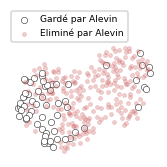

In [929]:
scatt,axi = plt.subplots(figsize=(1.5,1.5))

i2 = np.array([cb in whitelist_defaut for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.3, edgecolors = "black", label = "Gardé par Alevin",\
            s = 17, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in whitelist_defaut for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='o', label = "Eliminé par Alevin",\
            s = 7, vmin = -0.5, vmax = 1.5, alpha=0.3, color = "indianred", edgecolors = "indianred", linewidths=0.4)


# i3 = np.array([(cb not in whitelist_defaut and cb in knee_cbs_defaut) for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
#             s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)

axi.spines['right'].set_visible(False)
axi.spines['left'].set_visible(False)
axi.spines['bottom'].set_visible(False)
axi.spines['top'].set_visible(False)
axi.set_yticks([])
axi.set_xticks([])

plt.legend(loc=(0,1.01))
plt.tight_layout()
plt.savefig("./figs/ER1_after_filtering_defaut.pdf")

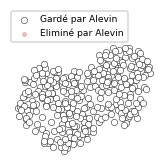

In [930]:
scatt,axi = plt.subplots(figsize=(1.5,1.5))

i2 = np.array([cb in whitelist_3000 for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.3, edgecolors = "black", label = "Gardé par Alevin",\
            s = 17, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in whitelist_3000 for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='o', label = "Eliminé par Alevin",\
            s = 7, vmin = -0.5, vmax = 1.5, alpha=0.4, color = "indianred", edgecolors = "indianred", linewidths=0.4)


# i3 = np.array([(cb not in whitelist_defaut and cb in knee_cbs_defaut) for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
#             s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)

axi.spines['right'].set_visible(False)
axi.spines['left'].set_visible(False)
axi.spines['bottom'].set_visible(False)
axi.spines['top'].set_visible(False)
axi.set_yticks([])
axi.set_xticks([])

plt.legend(loc=(0,1.01))
plt.tight_layout()
plt.savefig("./figs/ER1_after_filtering_3000.pdf")

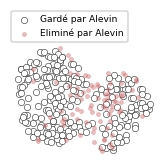

In [976]:
scatt,axi = plt.subplots(figsize=(1.5,1.5))

i2 = np.array([cb in whitelist_3000 for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.3, edgecolors = "black", label = "Gardé par Alevin",\
            s = 17, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in whitelist_3000 for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='o', label = "Eliminé par Alevin",\
            s = 7, vmin = -0.5, vmax = 1.5, alpha=0.4, color = "indianred", edgecolors = "indianred", linewidths=0.4)


# i3 = np.array([(cb not in whitelist_defaut and cb in knee_cbs_defaut) for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
#             s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)

axi.spines['right'].set_visible(False)
axi.spines['left'].set_visible(False)
axi.spines['bottom'].set_visible(False)
axi.spines['top'].set_visible(False)
axi.set_yticks([])
axi.set_xticks([])

plt.legend(loc=(0,1.01))
plt.tight_layout()
plt.savefig("./figs/ER1_after_filtering_3000.pdf")

In [ ]:
# rnaseq.setup.annotate_genes(sc)
# sc.obs["marker"] = sc.X.toarray()[:, sc.var["external_gene_name"].values == "TFF1"]

# scatt = plt.subplots(figsize=(3.2,0.8), sharey=True)
# for i,(c,p) in enumerate(zip(["total_UMIs", "processed_pseudogene", "DedupRate", "marker"],[1,0.5,2,1])):
#     axi = plt.subplot(1,5,i+1)
#     plt.title(c)
#     if c == "total_UMIs" :
#         plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = LogNorm())
#     else :
#         plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = PowerNorm(p))
#     plt.axis('off')

# plt.savefig("./figs/ER1_after_filtering_metrics.pdf")

In [931]:
sc.obs["marker"] = sc.X.toarray()[:, sc.var["external_gene_name"].values == "TFF1"]

In [932]:
metrics = ['total_UMIs', '#_genes', 'max_corr', 'MappingRate','DedupRate', 'genomic', 'marker']

powers_metrics = [0.1,0.3,0.8,1.3,1.5,0.5,0.8]

In [933]:
biotypes = ['rRNA', 'Mt_rRNA', 'mt_frac', 'rp_frac', 'lncRNA', 'processed_pseudogene', 'protein_coding']
powers_biotypes = [1,0.5,0.8,0.8,1.8,0.5, 0.8]

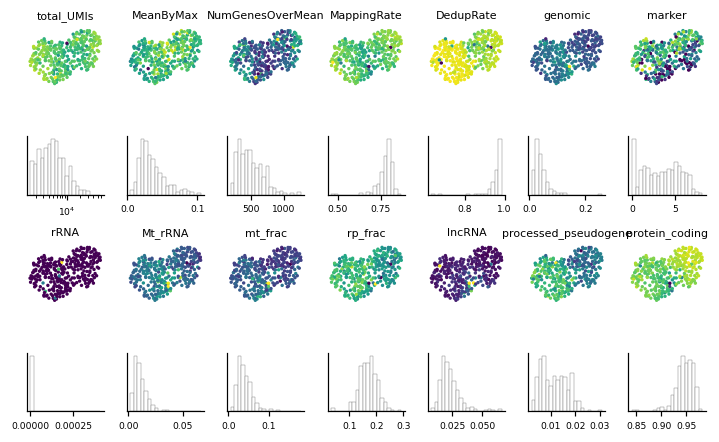

In [934]:
scatt = plt.subplots(figsize=(6.5,4), sharey=True)
for i,(c,p) in enumerate(zip(metrics,powers_metrics)):
    axi = plt.subplot(4,7,i+1)
    plt.title(c)
    plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = PowerNorm(p))
    plt.axis('off')

for j,c in enumerate(metrics):
    axi = plt.subplot(4,7,i+j+2)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_yticks([])
    if metrics[j] in ["total_UMIs", "#_genes"] :
        rnaseq.plotting.loghist(sc.obs[c],  bins = 20, color="white", edgecolor="gray", linewidth = 0.3, ax=axi);
    else :
        plt.hist(sc.obs[c],  bins = 20, color="white", edgecolor="gray", linewidth = 0.3);

for a,(c,p) in enumerate(zip(biotypes,powers_biotypes)):
    axi = plt.subplot(4,7,a+i+j+3)
    plt.title(c)
    plt.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], c = sc.obs[c], s = 1.5, norm = PowerNorm(p))
    plt.axis('off')

for b,c in enumerate(biotypes):
    axi = plt.subplot(4,7,b+i+j+10)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_yticks([])
    plt.hist(sc.obs[c],  bins = 20, color="white", edgecolor="gray", linewidth = 0.3);


plt.tight_layout()
plt.savefig("./figs/metrics_after_filtering.pdf")

In [ ]:
sc.X.shape

### ForceCells ER1

In [903]:
sample = "Sample_N705_-_ER1"
project = "dsp779"

whitelist = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/whitelist.txt", header=None)[0].values

In [904]:
len(whitelist)

2972

In [905]:
with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/aux_info/alevin_meta_info.json") as f:
    data = json.load(f)

In [906]:
data

{'total_reads': 159449547,
 'reads_with_N': 0,
 'noisy_cb_reads': 59284856,
 'noisy_umi_reads': 5077,
 'used_reads': 100159614,
 'mapping_rate': 52.723937810873814,
 'reads_in_eqclasses': 84068080,
 'total_cbs': 2280250,
 'used_cbs': 60426,
 'initial_whitelist': 3000,
 'low_conf_cbs': 997,
 'num_features': 7,
 'no_read_mapping_cbs': 4,
 'final_num_cbs': 2972,
 'deduplicated_umis': 2915133,
 'mean_umis_per_cell': 980,
 'mean_genes_per_cell': 494}

In [907]:
knee = data["initial_whitelist"]
low_conf = data["low_conf_cbs"]
f = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/quants_mat_rows.txt", header=None).values.ravel()
freq = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/raw_cb_frequency.txt", header=None, index_col=0).loc[f]
knee_cbs = freq[:knee].index
low_conf_cbs = freq[knee:knee+low_conf].index

#### Before filtering

In [970]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc.obs_names = sc.obs["CB"]

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/customWh-top-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [914]:
pred = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_3000}/{sample}/alevin/predictions.txt")

In [915]:
del pred["False_prob"]
pred.columns = ["true_prob","False_prob"]

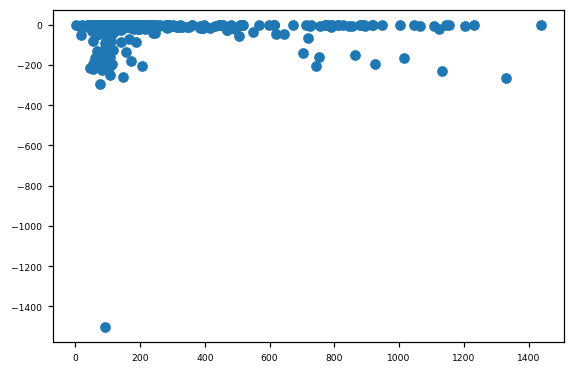

In [919]:
plt.scatter(sc.obs.loc[pred.index]["NumGenesExpressed"], pred["False_prob"]);

In [ ]:
sc.X.shape

In [971]:
rnaseq.pp.log_norm(sc, plot=False, inplace=True, ow = True, verbose = True)
scanpy.pp.pca(sc, n_comps=50)
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors=15)
scanpy.tl.umap(sc, n_components=2)

Normalization by total UMIs...
Log2 + 1 tranformation...


/tmp/ipykernel_44938/3788505321.py:9: UserWarning: You passed a edgecolor/edgecolors ('indianred') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\


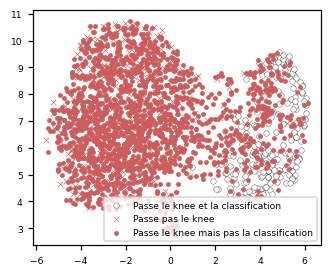

In [973]:
scatt = plt.subplots(figsize=(3,2.5))

i2 = np.array([cb in whitelist_3000 for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.2, edgecolors = "black", label = "Passe le knee et la classification",\
            s = 13, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in knee_cbs for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\
            s = 13, vmin = -0.5, vmax = 1.5, alpha=1, color = "indianred", edgecolors = "indianred", linewidths=0.4)


i3 = np.array([(cb not in whitelist_3000 and cb in knee_cbs) for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
            s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)


plt.legend()
plt.tight_layout()
plt.savefig("./figs/ER1_before_filtering_forcecells.pdf")

In [ ]:
i1.sum()+i2.sum()+i3.sum()

In [ ]:
sc.X.shape

In [ ]:
sc.obs[np.array([(cb in whitelist and cb not in knee_cbs) for cb in sc.obs_names])]

#### After filtering

In [ ]:
sc = rnaseq.readwrite.read_filtered(samples = {"dsp779": "ER1"})

In [ ]:
rnaseq.pp.log_norm(sc, plot=False, inplace=True, ow = True, verbose = True)
scanpy.pp.pca(sc, n_comps=50)
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors=15)
scanpy.tl.umap(sc, n_components=2)

In [ ]:
scatt = plt.subplots(figsize=(3,2.5))

i2 = np.array([cb in whitelist for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i2], sc.obsm["X_umap"][:,1][i2], linewidths=0.2, edgecolors = "black", label = "Passe le knee et la classification",\
            s = 13, vmin = -0.5, vmax = 1.5, color = "white")


i1 = np.array([cb not in knee_cbs for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i1], sc.obsm["X_umap"][:,1][i1], marker='x', label = "Passe pas le knee",\
            s = 13, vmin = -0.5, vmax = 1.5, alpha=1, color = "indianred", edgecolors = "indianred", linewidths=0.4)


i3 = np.array([(cb not in whitelist and cb in knee_cbs) for cb in sc.obs_names])
plt.scatter(sc.obsm["X_umap"][:,0][i3], sc.obsm["X_umap"][:,1][i3], label = "Passe le knee mais pas la classification", \
            s = 10, vmin = -0.5, vmax = 1.5, color = "indianred", alpha = 1, edgecolors = "black", linewidths=0)


# i4 = np.array([cb in low_conf_cbs for cb in sc.obs_names])
# plt.scatter(sc.obsm["X_umap"][:,0][i4], sc.obsm["X_umap"][:,1][i4], marker='v',\
#             s = 20, vmin = -0.5, vmax = 1.5, facecolor=(0.7,0.05,0.2,0.4), edgecolors = "black", linewidths=0.15)


plt.legend()
plt.tight_layout()
plt.savefig("./figs/ER1_after_filtering_forcecells.pdf")

In [ ]:
sc.X.shape

In [351]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_3000, genref = genref, cdna = "3' tag", exp = "sc", shuffle_samples=False)
sc.obs_names = sc.obs["CB"].tolist()

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [352]:
sc.obs["in_whitelist"] = [cb in whitelist_defaut for cb in sc.obs_names]

In [358]:
sc.obs[:len(whitelist_defaut)]["in_whitelist"].sum()

2947

In [359]:
len(whitelist_defaut)

2972

In [360]:
sc.obs

,CB,CorrectedReads,MappedReads,DeduplicatedReads,MappingRate,DedupRate,MeanByMax,NumGenesExpressed,NumGenesOverMean,mRnaFraction,rRnaFraction,raw_cb_freq,samples,project_id,in_whitelist
CAAAGCTCCTTC,CAAAGCTCCTTC,1165452,913460,16328,0.783782,0.982125,0.016884,4637,894,0.0,0.045096,1140054,Sample_N705_-_ER1,dsp779,True
CCCGAAGGATCC,CCCGAAGGATCC,1596991,1238932,22122,0.775791,0.982144,0.011824,5392,944,0.0,0.025338,1564769,Sample_N705_-_ER1,dsp779,True
CCTTGTCGCGTG,CCTTGTCGCGTG,1083544,887655,19620,0.819215,0.977897,0.013874,4417,723,0.0,0.051469,1050679,Sample_N705_-_ER1,dsp779,True
CATCTGGGCGAC,CATCTGGGCGAC,998569,825418,21276,0.826601,0.974224,0.018147,4346,939,0.0,0.028847,959270,Sample_N705_-_ER1,dsp779,True
CTCCACGGGATT,CTCCACGGGATT,1074452,854617,27978,0.795398,0.967263,0.017680,5949,1229,0.0,0.030377,1036238,Sample_N705_-_ER1,dsp779,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGTAGGGCGCTT,GGTAGGGCGCTT,2923,2074,41,0.709545,0.980231,0.227778,36,3,0.0,0.146341,2898,Sample_N705_-_ER1,dsp779,False
CGCTTAGATACA,CGCTTAGATACA,2887,2009,55,0.695878,0.972623,0.183333,50,1,0.0,0.145455,2887,Sample_N705_-_ER1,dsp779,False
GTTTCTGCGTCT,GTTTCTGCGTCT,2910,1900,98,0.652921,0.948421,0.269231,91,9,0.0,0.061225,2867,Sample_N705_-_ER1,dsp779,False
CCAGGCACCTCC,CCAGGCACCTCC,2920,1894,104,0.648630,0.945090,0.088889,78,13,0.0,0.163462,2877,Sample_N705_-_ER1,dsp779,False


In [419]:
sample = "Sample_N701_-_Not_Transfected"
quant_params_default = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/default"
quant_params_default = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000"
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/customWh-top-3000"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"

In [420]:
with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/aux_info/alevin_meta_info.json") as f:
    alevin_meta_info = json.load(f)

knee = alevin_meta_info["initial_whitelist"]
whitelist = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/alevin/whitelist.txt", header=None)[0].values
quants_mat_rows = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/alevin/quants_mat_rows.txt", header=None).values.ravel()
raw_cb_frequency = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/alevin/raw_cb_frequency.txt", header=None, index_col=0)
# freq = freq.sort_values(by=1, ascending=False)
# knee_cbs_defaut = freq[:knee].index

In [421]:
alevin_meta_info

{'total_reads': 115784803,
 'reads_with_N': 0,
 'noisy_cb_reads': 71670429,
 'noisy_umi_reads': 2327,
 'used_reads': 44112047,
 'mapping_rate': 32.97449493436544,
 'reads_in_eqclasses': 38179454,
 'total_cbs': 3156724,
 'used_cbs': 83814,
 'initial_whitelist': 3000,
 'low_conf_cbs': 1000,
 'num_features': 7,
 'final_num_cbs': 2073,
 'deduplicated_umis': 8608663,
 'mean_umis_per_cell': 4152,
 'mean_genes_per_cell': 2112}

In [422]:
print(len(quants_mat_rows))
print(knee)

4000
3000


In [423]:
print(len(whitelist))
print(len(np.intersect1d(raw_cb_frequency[:knee].index, whitelist)))
print(len(np.intersect1d(quants_mat_rows[:knee], whitelist)))

2073
2016
2073


In [429]:
raw_cb_frequency.loc[quants_mat_rows[:5]]

,1
0,
CTTCACCACCAA,140625
CATCAGGACATC,137868
CCCTATCCCTAG,150121
AATTTGCCGCTA,155642
CTCTTTCTTTCT,144547


In [424]:
print(len(whitelist))
print(len(np.intersect1d(raw_cb_frequency[:1500].index, whitelist)))
print(len(np.intersect1d(quants_mat_rows[:1500], whitelist)))

2073
1478
1500


In [412]:
print(len(np.intersect1d(quants_mat_rows, raw_cb_frequency[:len(quants_mat_rows)+alevin_meta_info["no_read_mapping_cbs"]].index))) 

3999


In [755]:
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/default"
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
sample = "Sample_N705_-_ER1"
sample = "Sample_N701_-_Not_Transfected"
# sample = "Sample_N707_-_ER2"
sample = "Sample_N702_-_CTR1"

In [413]:
# with open(f"./aux_info/alevin_meta_info.json") as f:
#     alevin_meta_info = json.load(f)

# knee_or_threshold = alevin_meta_info["initial_whitelist"]
# whitelist = pd.read_table(f"./alevin/whitelist.txt", header=None)[0].values
# quants_mat_rows = pd.read_table(f"./alevin/quants_mat_rows.txt", header=None).values.ravel()
# raw_cb_frequency = pd.read_table(f"./alevin/raw_cb_frequency.txt", header=None, index_col=0)

In [767]:
with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/aux_info/alevin_meta_info.json") as f:
    alevin_meta_info = json.load(f)

knee_or_threshold = alevin_meta_info["initial_whitelist"]
whitelist = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/whitelist.txt", header=None)[0].values
quants_mat_rows = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/quants_mat_rows.txt", header=None).values.ravel()
raw_cb_frequency = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/raw_cb_frequency.txt", header=None, index_col=0)

features = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/featureDump.txt", header=0, index_col=0)

In [757]:
alevin_meta_info

{'total_reads': 145095156,
 'reads_with_N': 0,
 'noisy_cb_reads': 66182273,
 'noisy_umi_reads': 3866,
 'used_reads': 78909017,
 'mapping_rate': 44.93378883027631,
 'reads_in_eqclasses': 65196751,
 'total_cbs': 3146561,
 'used_cbs': 92693,
 'initial_whitelist': 3000,
 'low_conf_cbs': 1000,
 'num_features': 7,
 'no_read_mapping_cbs': 1,
 'final_num_cbs': 2597,
 'deduplicated_umis': 6871590,
 'mean_umis_per_cell': 2645,
 'mean_genes_per_cell': 1370}

In [758]:
print(len(quants_mat_rows))
print(knee_or_threshold)

3999
3000


In [759]:
print(len(whitelist))
print(len(np.intersect1d(raw_cb_frequency[:knee_or_threshold].index, whitelist)))
print(len(np.intersect1d(quants_mat_rows[:knee_or_threshold], whitelist)))

2597
2513
2597


In [760]:
print(len(np.intersect1d(raw_cb_frequency[:1500].index, whitelist)))
print(len(np.intersect1d(quants_mat_rows[:1500], whitelist)))

1495
1500


In [761]:
print(len(np.intersect1d(quants_mat_rows, raw_cb_frequency[:len(quants_mat_rows) + alevin_meta_info["no_read_mapping_cbs"]].index))) 

3999


In [796]:
features["raw_cb_freq"] = raw_cb_frequency.loc[quants_mat_rows]

In [795]:
list(features.index) == list(quants_mat_rows)

True

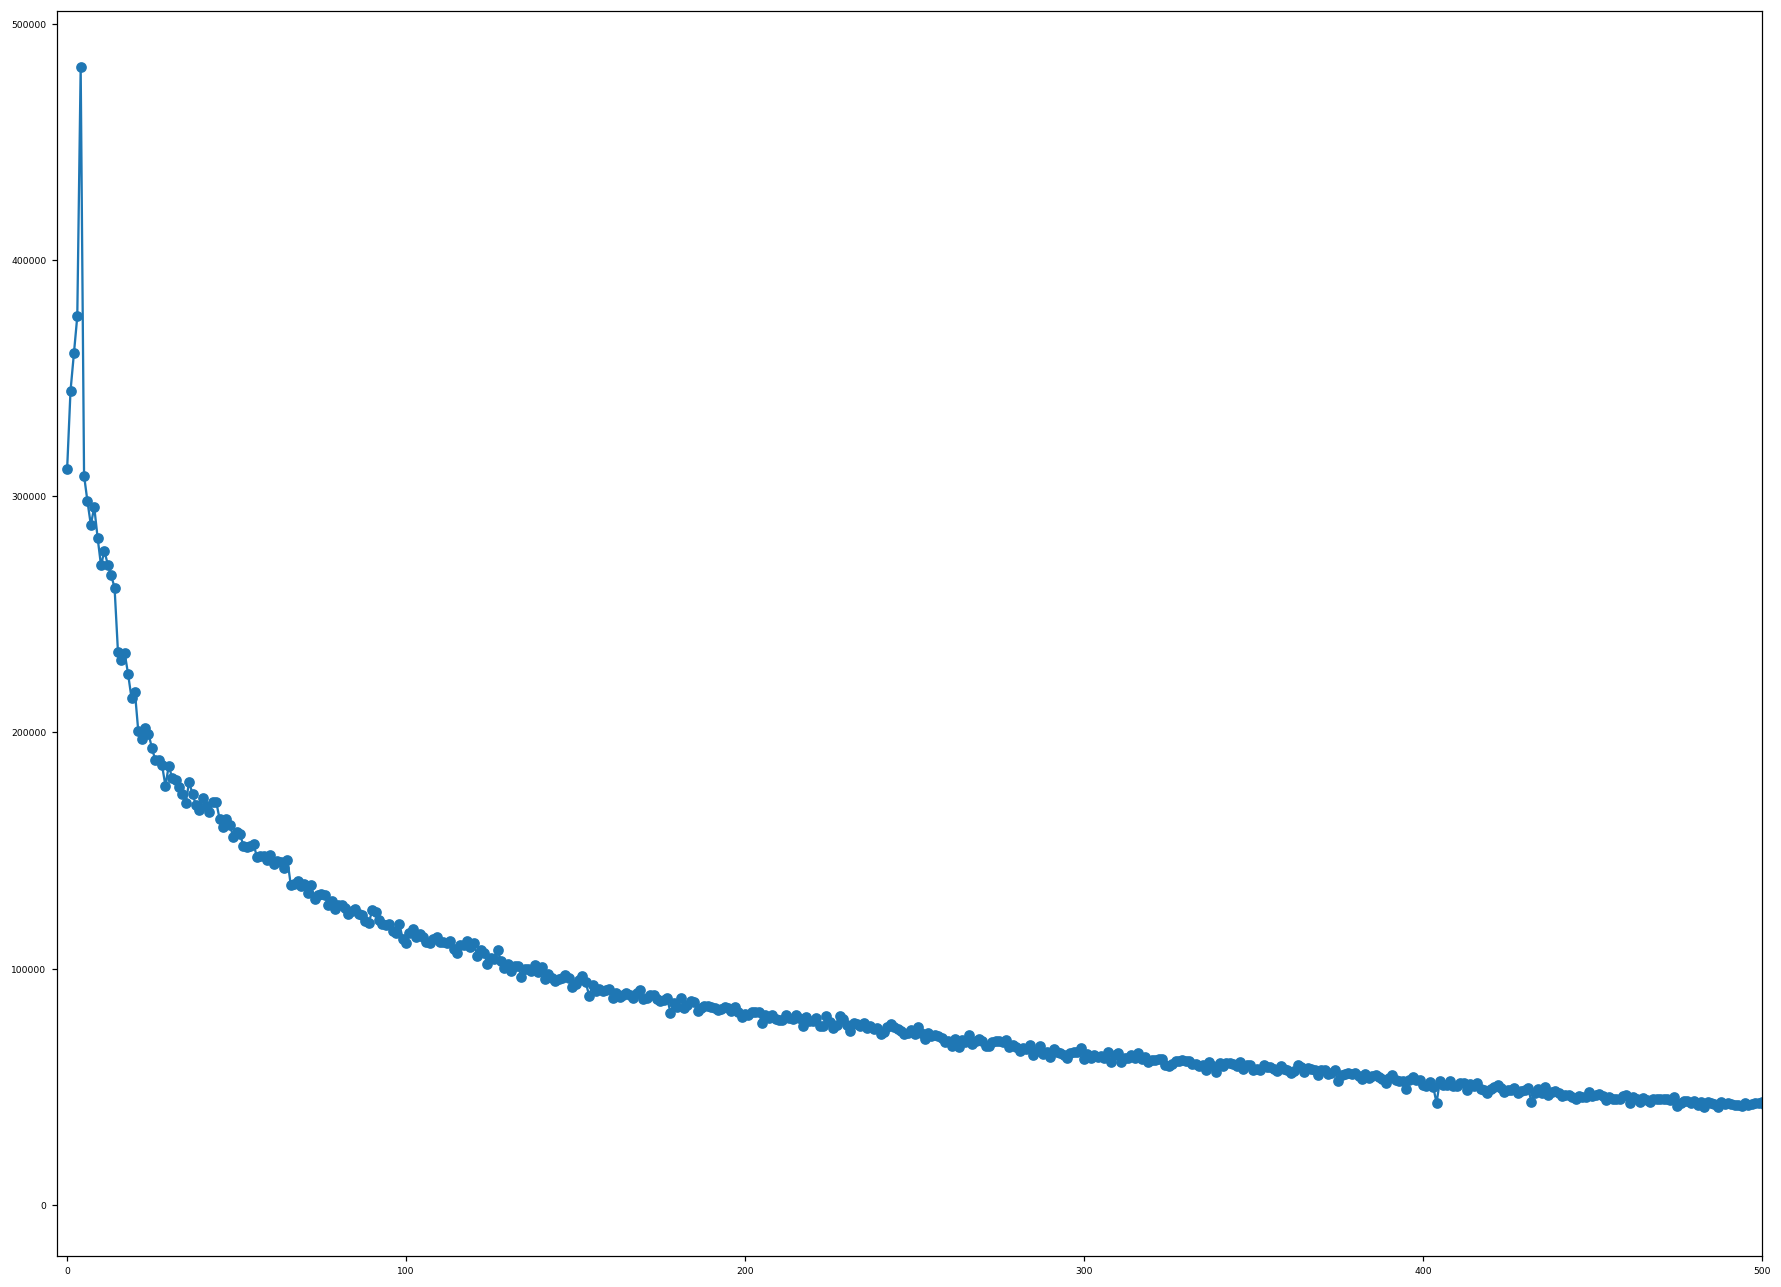

In [806]:
plt.subplots(figsize=(20,15))
plt.plot(features["raw_cb_freq"].values, marker='o')
plt.xlim(-3, 500);

In [789]:
list(features["MappedReads"].values) == sorted(list(features["MappedReads"].values))

False

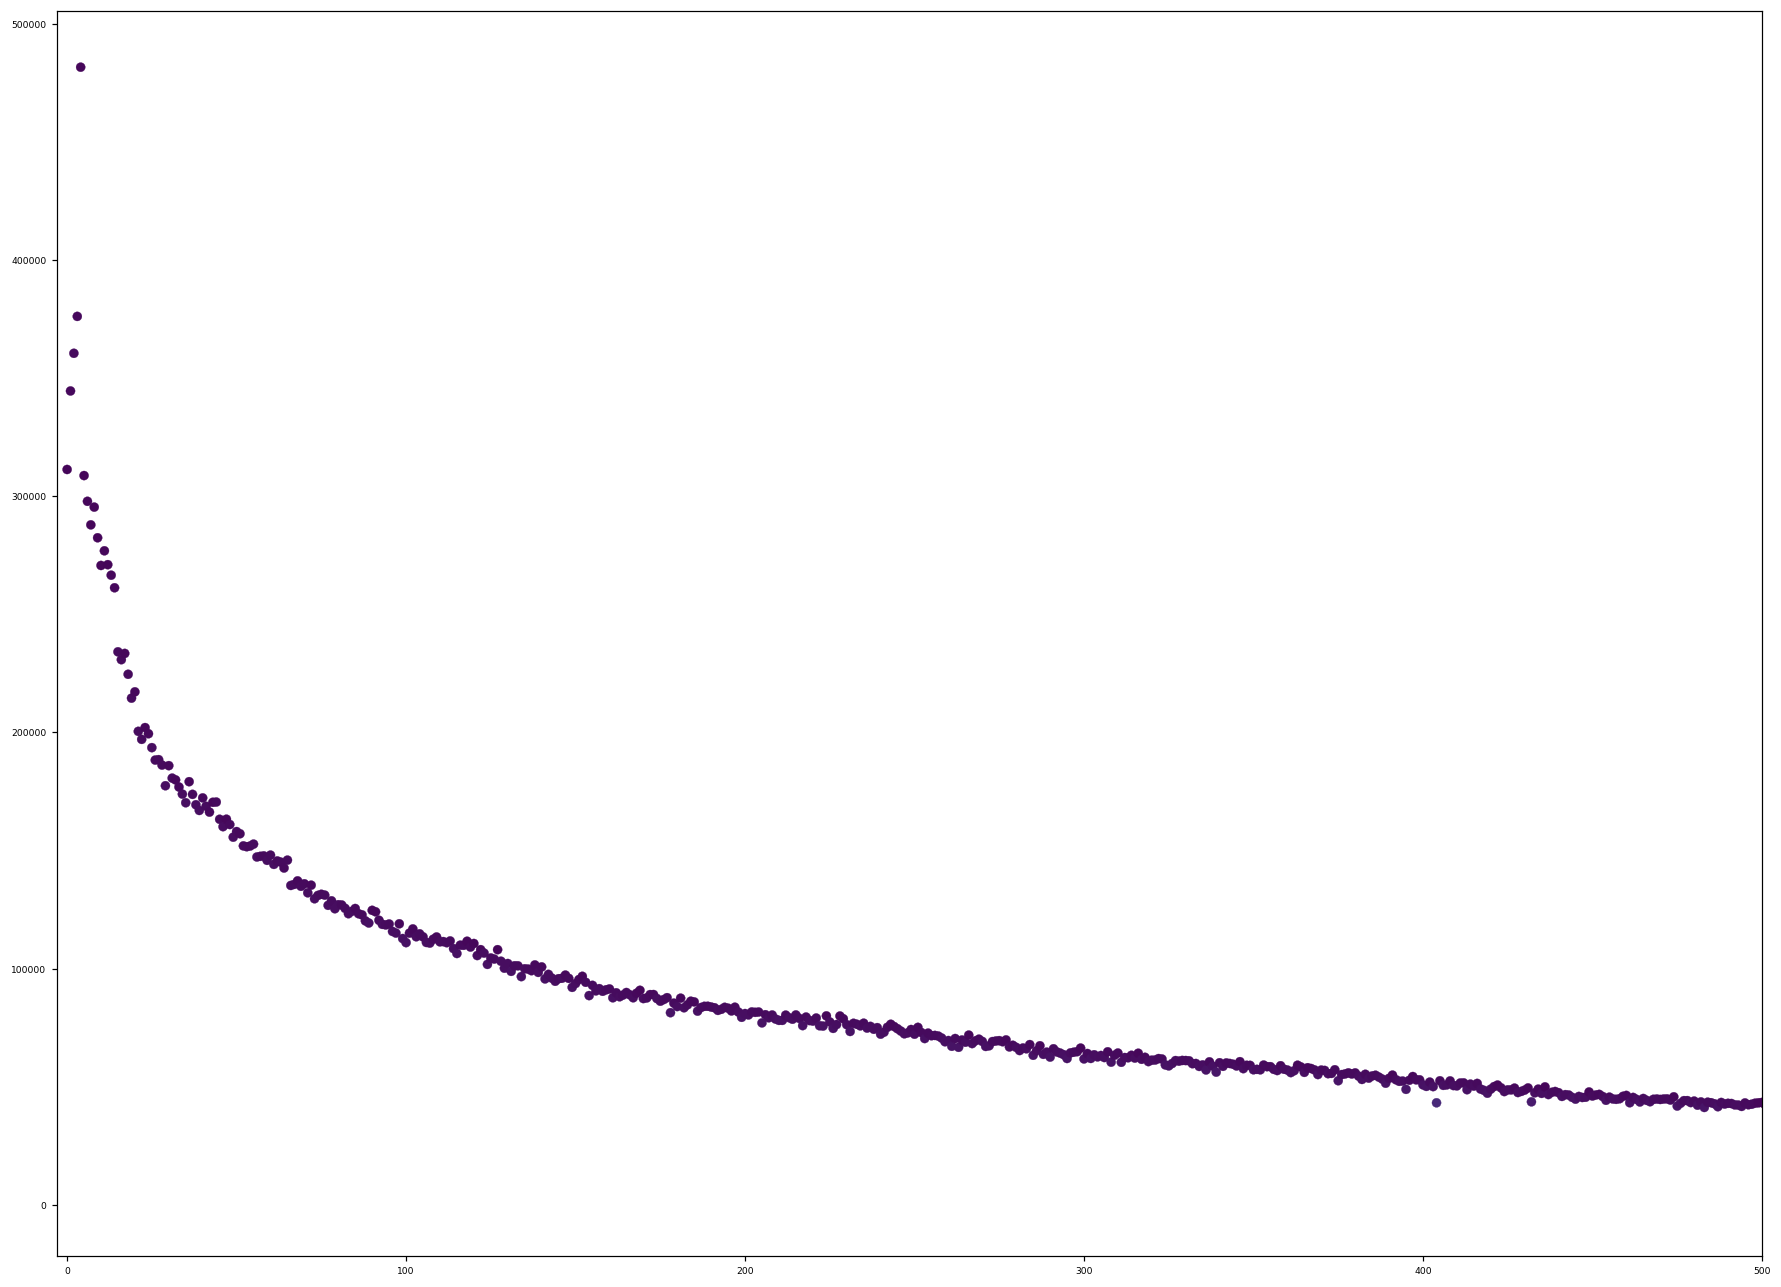

In [798]:
CorrRate = features["CorrectedReads"].values / raw_cb_frequency.loc[quants_mat_rows].values.ravel()
plt.subplots(figsize=(20,15))
plt.scatter(np.arange(len(quants_mat_rows)), features["raw_cb_freq"].values, marker='o', linewidth=0.2, c = CorrRate)
plt.xlim(-3,500);

In [729]:
quants_mat_rows

array(['CAAAGCTCCTTC', 'CCCGAAGGATCC', 'CCTTGTCGCGTG', ...,
       'GTTTCTGCGTCT', 'CCAGGCACCTCC', 'GAGTGAGCTCAG'], dtype=object)

In [731]:
raw_cb_frequency.loc[quants_mat_rows]

,1
0,
CAAAGCTCCTTC,1140054
CCCGAAGGATCC,1564769
CCTTGTCGCGTG,1050679
CATCTGGGCGAC,959270
CTCCACGGGATT,1036238
...,...
GGTAGGGCGCTT,2898
CGCTTAGATACA,2887
GTTTCTGCGTCT,2867


In [377]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_3000, genref = genref, cdna = "3' tag", exp = "sc", shuffle_samples=False)
sc.obs_names = sc.obs["CB"].tolist()

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
